In [1]:
from collections import defaultdict
import rsa_io
import rsa
import argparse
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [2]:
# Sena's folders
#eeg_root_path = "/home/sena/Desktop/set_test/"
#model_root_path = "/home/sena/PycharmProjects/CCN-RSA/Models/"
#save_path = "/home/sena/PycharmProjects/CCN-RSA/results/"

In [3]:
# Hüseyin's folders

eeg_root_path = "/Users/huseyinelmas/Desktop/CCN-Lab/data/set_test/"   
model_root_path = "/Users/huseyinelmas/Desktop/CCN-Lab/RSA-Models/"
save_path = "/Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/Results/"

In [4]:
w_size = 1
save_eeg_rdms = True
eeg_rdm_dist_metric = 'correlation'
model_rdm_dist_metric = 'correlation'
model_RDM_path = save_path + 'modelRDMs/'
eeg_RDM_path = save_path + 'eegRDMs/'

In [5]:
# Create modelRDMs folder in models if not exists
model_rdm_path = save_path + "modelRDMs/"
if not os.path.exists(model_rdm_path):
    os.makedirs(model_rdm_path)

# Create eegRDMs folder in models if not exists
eeg_rdm_path = save_path + "eegRDMs/"
if not os.path.exists(eeg_rdm_path):
    os.makedirs(eeg_rdm_path)

In [6]:
subject_folders = [name for name in os.listdir(eeg_root_path) if
                   os.path.isdir(eeg_root_path + name) and name.startswith("subj")]
n_subjects = len(subject_folders)

In [7]:
# Check if eeg_rdm exists in eeg_rdm_path, meaning that experiment is already done with this w_size and eeg_rdm_distance
eeg_rdm_fname = "eeg_rdm_" + str(w_size) + "_" + eeg_rdm_dist_metric
eeg_rdm_ready = False
if eeg_rdm_fname + ".hdf5" in os.listdir(eeg_rdm_path):
    print("EEG RDMs with parameters with window size: {0} and distance: {1} is already created, loading from {2}".format(str(w_size) ,  eeg_rdm_dist_metric, eeg_rdm_path + eeg_rdm_fname))
    windowed_eeg_rdm_dict, attributes = rsa_io.load_from_hdf5(eeg_rdm_fname,eeg_rdm_path)
    eeg_rdm_ready = True

EEG RDMs with parameters with window size: 1 and distance: correlation is already created, loading from /Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/Results/eegRDMs/eeg_rdm_1_correlation
Dataset attributes of eeg_rdm_1_correlation [('distance_metric', 'correlation'), ('w_size', 1)]


In [8]:
# Check if every model rdm was already created in model_RDM_path if all model_rdms exists
# No need to create all over, saves computation
model_RDM_dict = {}
for model_file in os.listdir(model_root_path):
    if not model_file.startswith("."):
        model_name = os.path.splitext(model_file)[0] + "_" + model_rdm_dist_metric
        if not model_name + '.npy' in os.listdir(model_rdm_path):
            model = rsa_io.load_model(file_path=model_root_path + model_file)
            model_RDM_dict[model_name] = rsa.create_rdm(model.values, metric=model_rdm_dist_metric, name=model_name,
                                                        save_path=model_RDM_path, model=True)
        else:
            print("Model RDM for {0} with distance metric: {1} was found in {2},"
                  " loading already created Model RDM ".format(model_name, model_rdm_dist_metric, model_rdm_path))
            model_RDM_dict[model_name] = rsa_io.load_rdm(model_rdm_path + model_name)


Model RDM for movement_nature_correlation with distance metric: correlation was found in /Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/Results/modelRDMs/, loading already created Model RDM 
Model RDM for action_intention_correlation with distance metric: correlation was found in /Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/Results/modelRDMs/, loading already created Model RDM 
Model RDM for action_target_correlation with distance metric: correlation was found in /Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/Results/modelRDMs/, loading already created Model RDM 
Model RDM for biological_appearance_correlation with distance metric: correlation was found in /Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/Results/modelRDMs/, loading already created Model RDM 
Model RDM for action_category_correlation with distance metric: correlation was found in /Users/huseyinelmas/Desktop/CCN-Lab/CCN-RSA/Results/modelRDMs/, loading already created Model RDM 
Model RDM for agent_correlation with distance metric: c

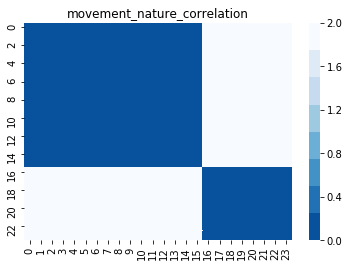

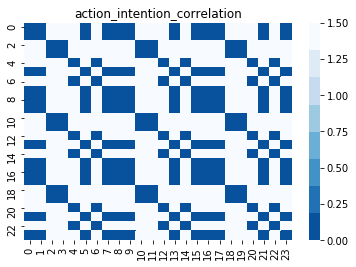

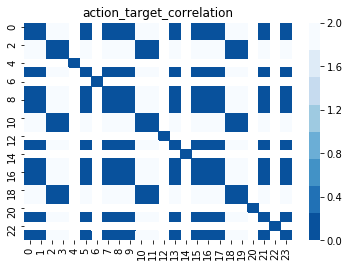

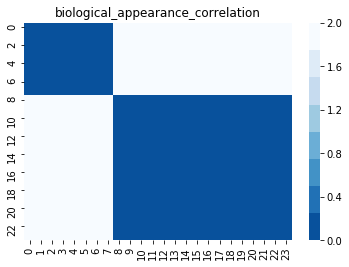

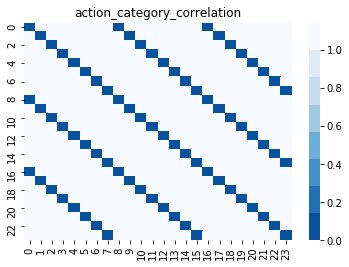

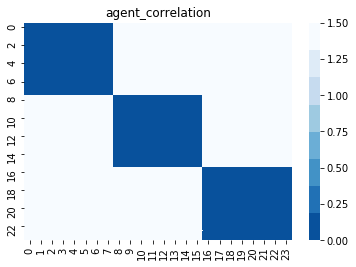

In [9]:
for model_name, model in model_RDM_dict.items():
    rsa.visualizeRDM(model, model_name, model_RDM_path+model_name)

In [10]:
if not eeg_rdm_ready:
    # every key is time point and every value is a list of corresponding rdms of different subjects
    windowed_eeg_rdm_dict = defaultdict(list)

    # For all subjects do
    for i, subject_folder in enumerate(subject_folders):
        subj_name = subject_folder[0:9]
        subj_path = eeg_root_path + subject_folder + "/action-mats/"

        # Keys are time windows, Each value in the time_window_representations is a 3D ndarray
        # with size (n_conditions, n_trials, n_channels). Since n_trials are not same for each condition,
        # the missing values are filled with NaN.
        time_window_representations = rsa_io.build_eeg_data(subj_path, w_size, subj_name)

        # traverse each window in time_window_representations and calculate rdm
        
        # TODO: values of windowed_eeg_rdm_dict may be not a list
        #  but 3d numpy array (n_subjects, n_conditions, n_conditions)
        for window, eeg_data in time_window_representations.items():
            eeg_rdm_name = subj_name + '_eeg_rdm_' + str(window[0]) + ":" + str(window[1]) + "_" + eeg_rdm_dist_metric
            windowed_eeg_rdm_dict[window].append(rsa.create_rdm(eeg_data, eeg_rdm_dist_metric, eeg_rdm_name))

    for window, eeg_rdm_list in windowed_eeg_rdm_dict.items():
        windowed_eeg_rdm_dict[window] = np.vstack(eeg_rdm_list)

    # Save eeg rdms to hdf5 file
    rsa_io.save_to_hdf5(windowed_eeg_rdm_dict, eeg_rdm_dist_metric, w_size, eeg_rdm_fname, eeg_rdm_path)

In [11]:
rdm_statistics_list = []
for model_name, model_RDM in model_RDM_dict.items():
    for time_window, EEG_RDM_list in windowed_eeg_rdm_dict.items():
        kendall_tau, kendall_p_value = rsa.correlate_models(model_RDM, np.mean(EEG_RDM_list, axis=0))
        rdm_statistics_list.append([model_name, time_window, kendall_tau, kendall_p_value])

In [12]:
pd.options.display.width = 100
rdm_statistics_df = pd.DataFrame(rdm_statistics_list,
                                 columns=['Model name', 'Time window', 'Kendall tau', 'Kendall p-value'])
pos_corr_rdms =  rdm_statistics_df[rdm_statistics_df["Kendall tau"]>0]

n_test = 1
# Apply Bonferroni correction?
correct = False
if correct:
    n_test = 400
significant_rdms = pos_corr_rdms[pos_corr_rdms["Kendall p-value"]/2<=(0.05)/n_test] #pos_corr_rdms[pos_corr_rdms["Kendall p-value"]<=(0.05/2)]

print(significant_rdms.sort_values(by="Kendall tau", ascending=False))

                             Model name Time window  Kendall tau  Kendall p-value
768        action_intention_correlation    (70, 71)     0.233910         0.000002
49          movement_nature_correlation  (142, 143)     0.233471         0.000002
769        action_intention_correlation    (71, 72)     0.233285         0.000002
50          movement_nature_correlation  (143, 144)     0.230860         0.000003
48          movement_nature_correlation  (141, 142)     0.225713         0.000005
51          movement_nature_correlation  (144, 145)     0.224072         0.000006
766        action_intention_correlation    (69, 70)     0.214385         0.000014
770        action_intention_correlation    (72, 73)     0.211573         0.000018
52          movement_nature_correlation  (145, 146)     0.211093         0.000019
47          movement_nature_correlation  (140, 141)     0.210273         0.000020
61          movement_nature_correlation  (153, 154)     0.209154         0.000022
62          move

In [13]:
print(significant_rdms.sort_values(by="Kendall p-value", ascending=True).head(10))

                       Model name Time window  Kendall tau  Kendall p-value
768  action_intention_correlation    (70, 71)     0.233910         0.000002
49    movement_nature_correlation  (142, 143)     0.233471         0.000002
769  action_intention_correlation    (71, 72)     0.233285         0.000002
50    movement_nature_correlation  (143, 144)     0.230860         0.000003
48    movement_nature_correlation  (141, 142)     0.225713         0.000005
51    movement_nature_correlation  (144, 145)     0.224072         0.000006
766  action_intention_correlation    (69, 70)     0.214385         0.000014
770  action_intention_correlation    (72, 73)     0.211573         0.000018
52    movement_nature_correlation  (145, 146)     0.211093         0.000019
47    movement_nature_correlation  (140, 141)     0.210273         0.000020


In [14]:
plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.close() # Close a figure window

In [15]:
# Calculate noise ceiling
upper_ceiling_list = []
lower_ceiling_list = []
for time_window, EEG_RDM_list in windowed_eeg_rdm_dict.items():
    lower_ceiling, upper_ceiling = rsa.calculateNoiseCeiling(EEG_RDM_list)
    lower_ceiling_list.append(lower_ceiling)
    upper_ceiling_list.append(upper_ceiling)
#x = [str(wind) for wind in windowed_eeg_rdm_dict.keys()]

In [16]:
rdm_statistics_df = rdm_statistics_df.sort_values(by="Time window")

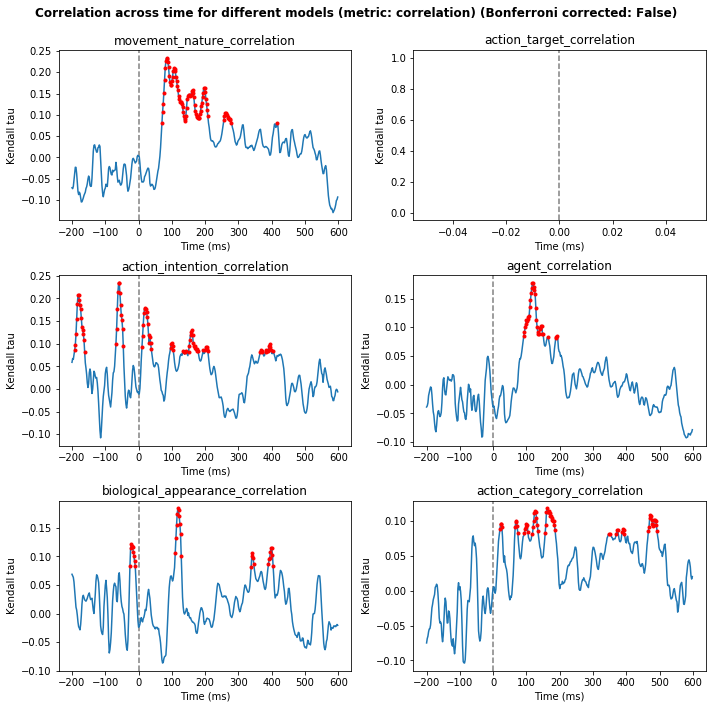

In [17]:
models = rdm_statistics_df['Model name'].unique()
fig, axs = plt.subplots(3,2, figsize=(10,10))#models.size)
fig.suptitle('Correlation across time for different models (metric: {0}) (Bonferroni corrected: {1})'.format(model_rdm_dist_metric, correct), weight='bold')

for i, model in enumerate(models):
    model_df = rdm_statistics_df.loc[rdm_statistics_df['Model name'] == model]
    t_arr = [2*(t-100) for t, _ in model_df['Time window'].values]
    
    x = i%3
    y = int(i/3)

    axs[x][y].set_title(model)
    # show starting understanding and chance level
    axs[x][y].axvline(x=0, color='black', alpha=0.5, linestyle='--', label='end of baseline period')
    #axs[x][y].fill_between(t_arr, lower_ceiling_list, upper_ceiling_list, color='grey', alpha=.5)
    sig_pts = [sig for sig, _ in significant_rdms.loc[rdm_statistics_df['Model name'] == model]['Time window'].values]
    axs[x][y].plot(t_arr, model_df['Kendall tau'], marker='.', markeredgecolor='r', markerfacecolor='r', markevery=sig_pts)


    
for ax in axs.flat:
    ax.set(xlabel='Time (ms)', ylabel='Kendall tau')
    #ax.label_outer()
    
fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.savefig(save_path + 'eeg_metric_' + eeg_rdm_dist_metric + '_model_metric_' + model_rdm_dist_metric + '_Bonferroni_corrected_{0}'.format(correct) + '_3by2.png')
plt.show()

In [18]:
rdm_statistics_df[rdm_statistics_df['Model name']=='action_target_correlation']

,Model name,Time window,Kendall tau,Kendall p-value
800,action_target_correlation,"(0, 1)",NaN,NaN
801,action_target_correlation,"(1, 2)",NaN,NaN
912,action_target_correlation,"(2, 3)",NaN,NaN
1023,action_target_correlation,"(3, 4)",NaN,NaN
1134,action_target_correlation,"(4, 5)",NaN,NaN
1145,action_target_correlation,"(5, 6)",NaN,NaN
1156,action_target_correlation,"(6, 7)",NaN,NaN
1167,action_target_correlation,"(7, 8)",NaN,NaN
1178,action_target_correlation,"(8, 9)",NaN,NaN
1189,action_target_correlation,"(9, 10)",NaN,NaN


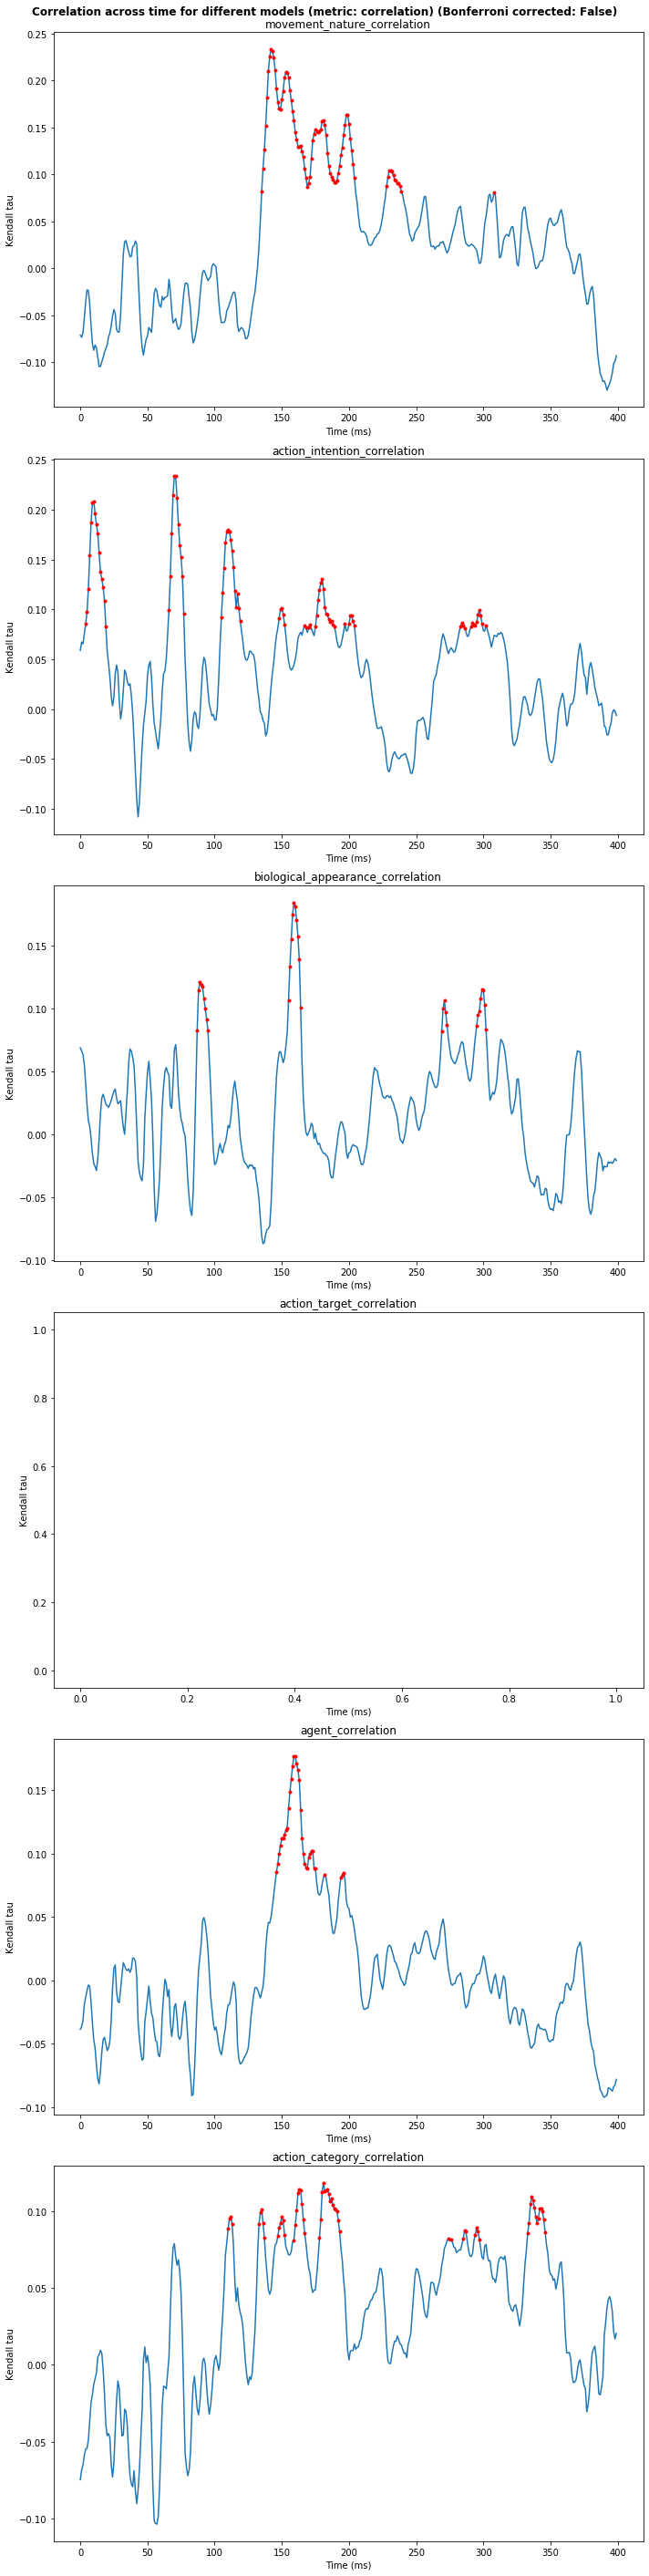

In [19]:
models = rdm_statistics_df['Model name'].unique()
fig, axs = plt.subplots(models.size, figsize = (10,40))
fig.suptitle('Correlation across time for different models (metric: {0}) (Bonferroni corrected: {1})'.format(model_rdm_dist_metric, correct) , weight='bold')

for i, model in enumerate(models):
    model_df = rdm_statistics_df.loc[rdm_statistics_df['Model name'] == model]
    t_arr = [t for t, _ in model_df['Time window'].values]

    axs[i].set_title(model)
    

    #ax=fig.add_subplot()
    #axs[i].fill_between(t_arr, lower_ceiling_list, upper_ceiling_list, color='grey', alpha=.5)
    
    sig_pts = [sig for sig, _ in significant_rdms.loc[rdm_statistics_df['Model name'] == model]['Time window'].values]
    axs[i].plot(t_arr, model_df['Kendall tau'], marker='.', markeredgecolor='r', markerfacecolor='r', markevery=sig_pts)
    
for ax in axs.flat:
    ax.set(xlabel='Time (ms)', ylabel='Kendall tau')
    #ax.label_outer()
    
fig.tight_layout()
fig.subplots_adjust(top=0.97)
fig.savefig(save_path + 'eeg_metric_' + eeg_rdm_dist_metric  + '_model_metric_' + model_rdm_dist_metric+ '_Bonferroni_corrected_{0}'.format(correct) +'_6by1.png')
plt.show()